# 0. Set Up

In [1]:
# Import packages
import numpy as np
import pandas as pd

from sklearn.isotonic import IsotonicRegression
from scipy.stats import norm, gamma
from scipy import interpolate, optimize, integrate

import matplotlib.pyplot as plt
import seaborn as sns

import copy
import random
import itertools
import time

In [2]:
# Set random seed
np.random.seed(1)

# 1. Define the W_Stress Class

In [3]:
class W_Stress:

    def __init__(self, data, u, bracket=None):
        self.ir = IsotonicRegression()
        self.data = data
        self.u = u

        nY = 500
        y = np.linspace(0.9 * np.quantile(data["y"], 0.005), np.quantile(data["y"], 0.995) * 1.1, nY)
        self.y = y

        self.h_y = 1.06 * np.std(data["y"]) * (len(data["y"])) ** (-1 / 5)
        if "x" in data:
            self.h_x = 1.06 * np.std(data["x"], axis=0) * (len(data["y"])) ** (-1 / 5)

        self.f = lambda y: np.sum(norm.pdf((np.array(y).reshape(-1, 1) - data["y"].reshape(1, -1)) / self.h_y) /
                                  self.h_y / len(data["y"]), axis=1).reshape(-1)

        self.F = lambda y: np.sum(norm.cdf((np.array(y).reshape(-1, 1) - data["y"].reshape(1, -1)) / self.h_y) / len(data["y"]),
                                  axis=1).reshape(-1)

        if not bracket:
            bracket = [-10, 20]
        F_inv = lambda u: optimize.root_scalar(lambda y: (self.F(np.array([y])) - u), method='Brentq',
                                               bracket=bracket)

        self.F_inv = np.zeros(len(u))
        for i in range(len(u)):
            self.F_inv[i] = F_inv(u[i]).root

        # Initialize
        self.Gs_inv = None
        self.gammas = []
        self.gs = None
        self.Gs = None

    # Static functions
    @staticmethod
    def integrate(f, u):
        # integral of f over space x using Reimann sums
        return np.sum(0.5 * (f[:-1] + f[1:]) * np.diff(u))

    @staticmethod
    def double_integral(f, x, y):
        # integrate f over x and y using double Reimann sums
        # f is of size MxN, x is of size N, y is of size M
        x_diff = np.diff(x)
        y_diff = np.diff(y)
        areas = np.outer(y_diff, x_diff)

        # Currently using a corner - more accurate to use centre of area?
        return np.sum(np.multiply(f[:-1, :-1], areas))

    @staticmethod
    def empirical(x):
        n = len(x)

        empirical_dist = np.zeros(n)
        for i in range(n):
            k = len(np.where(x <= x[i])[0])
            empirical_dist[i] = k/n

        return empirical_dist
    
    # Plot functions
    def plot_G_inv(self, G_inv, title=""):

        fig = plt.figure(figsize=(4, 4))
        plt.plot(self.u, G_inv, label=r"$\breve{G}^*_Y$", color='r')
        plt.plot(self.u, self.F_inv, linestyle='--', color='b', label=r"$\breve{F}_Y$")
        plt.title(title)
        plt.legend(fontsize=14)

        plt.yscale('log')

        plt.show()

        return

    def plot_ell_iso(self, ell, title=""):

        fig = plt.figure(figsize=(4, 4))
        plt.plot(self.u, ell, linewidth=0.5, color='g', label=r"$\ell$")
        plt.plot(self.u, self.Gs_inv, label=r"$\breve{G}^*_Y$", color='r')
        plt.plot(self.u, self.F_inv, linestyle='--', color='b', label=r"$\breve{F}_Y$")
        plt.title(title)
        plt.legend(fontsize=14)

        plt.yscale('log')

        plt.show()

        return fig

    def plot_ell(self, ell):

        fig = plt.figure(figsize=(4, 4))
        plt.subplot(2, 1, 1)
        plt.plot(self.u, ell, linewidth=0.5, color='g', label=r"$\ell$")
        plt.legend(fontsize=14)
        plt.yscale('log')

        plt.subplot(2, 1, 2)
        plt.plot(self.u, ell, linewidth=0.5, color='g', label=r"$\ell$")
        plt.plot(self.u, self.Gs_inv, linestyle='--', label=r"$\breve{G}^*_Y$", color='r')
        plt.legend(fontsize=14)
        plt.yscale('log')

        plt.show()

        return fig

    def plot_f_F(self):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        ax2 = ax[0].twinx()

        ax[0].plot(self.y, self.f(self.y), color='k')
        ax2.plot(self.y, self.F(self.y), color='r')

        ax[0].set_xlabel(r"$y$", fontsize=16)
        ax[0].set_ylabel(r"$f(y)$", fontsize=16)
        ax2.set_ylabel(r"$F(y)$", fontsize=16, color='r')
        ax2.set_ylim(0, 1.02)

        ax[1].plot(self.u, self.F_inv)
        ax[1].set_ylabel(r"$F^{-1}(y)$", fontsize=16)
        ax[1].set_xlabel(r"$y$", fontsize=16)

        plt.tight_layout(pad=1)

        plt.show()
        return

    def plot_sensitivities(self, sensitivity_measures, filename, colors, labels, title=None, save=True):
        n = len(sensitivity_measures)
        w = round(1/n, 1) - 0.1

        scale = - np.floor(n/2)
        for i in range(n):
            if n%2 == 0:
                plt.bar(np.arange(10) + scale * w, sensitivity_measures[i], color=colors[i],
                    label=labels[i], width=w)
                scale += 1

            else:
                plt.bar(np.arange(10) + scale * w, sensitivity_measures[i], color=colors[i],
                        label=labels[i], width=w)
                scale += 1

        plt.title(title, fontsize=14)
        plt.xlabel('L')
        plt.ylim(-1,1)
        plt.legend(loc='lower left', fontsize=14)

        if save:
            plt.savefig(filename, format='pdf')

        plt.show()

    def plot_dist(self, filename, type="", title="", save=True):
        y_P = np.linspace(self.F_inv[5], self.F_inv[-5], 1000)
        y_Q = np.linspace(self.Gs_inv[3], self.Gs_inv[-3], 1000)

        self.set_distribution(self.u, self.Gs_inv, y_Q)

        fig = plt.figure(figsize=(5, 4))
        plt.plot(y_Q, self.gs(y_Q), color='r', label='$g^*_Y$')
        plt.plot(y_P, self.f(y_P), '--', color='b', label='$f_Y$')
        plt.ylim(bottom=0)
        plt.title(title)
        plt.show()

        if save:
            fig.savefig(filename + '_density.pdf', format='pdf')

        fig = plt.figure(figsize=(5, 4))
        plt.plot(y_Q, self.Gs(y_Q), color='r', label='$G^*_Y$')
        plt.plot(y_P, self.F(y_P), '--', color='b', label='$F_Y$')
        plt.legend(fontsize=14)
        plt.title(title)
        plt.show()

        if save:
            fig.savefig(filename + '_CDF.pdf', format='pdf')

        idx = np.where(np.diff(self.Gs_inv) < 1e-8)[0][0]

        fig = plt.figure(figsize=(4, 4))

        dQ_dP = self.gs(y_Q) / self.f(y_Q)
        if type == "ES":
            dQ_dP[:idx] = 1
        plt.plot(y_Q, dQ_dP)

        plt.ylim(0, 15)
        plt.xlabel(r"$y$", fontsize=18)
        plt.ylabel(r"$\frac{g^{*}_Y}{f_Y}$", fontsize=22)
        plt.tight_layout()
        plt.show()

        if save:
            fig.savefig(filename + '_RN.pdf', format='pdf')

    
    def plot_xdensity(self, filename, save=True):
        y_Q = np.linspace(self.Gs_inv[3], self.Gs_inv[-3], 1000)

        # Get index for x- and y-values
        idx = (self.data["y"] >= y_Q[0]) & (self.data["y"] <= y_Q[-1])

        # Get adjusted g*/f
        w = self.get_weights()

        data_y_idx = self.data["y"][idx]
        data_x_idx = self.data["x"][idx]
        w_idx = w[idx]

        num_inputs = self.data['x'].shape[1]
        nrows = int(np.ceil(num_inputs/2))
        fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,10))

        ind = 0
        for i in range(nrows):
            for j in range(2):
                x_axis = np.linspace(0.9 * np.quantile(self.data["x"][:, ind], 0.005),
                                     np.quantile(self.data["x"][:, ind], 0.995) * 1.1,
                                     len(w))

                f_x = self.f_x(self.data["x"][:, ind], self.h_x[ind])  # under P: KDE of marginal distribution of xi
                gs_x = self.gs_x(self.data["x"][:, ind], self.h_x[ind], w)  # under Q: KDE of marginal distribution of xi

                mean_f = np.mean(self.data["x"][:, ind])
                mean_gs = np.sum(self.data["x"][:, ind] * w) / np.sum(w)

                ax[i, j].plot(x_axis, f_x(x_axis), color='blue', label='$f_X$')
                ax[i, j].plot(x_axis, gs_x(x_axis), color='red', label='$g^*_X$')
                ax[i, j].axvline(x=mean_f, color='blue', linestyle='dashed', label='E[$f_X$]')
                ax[i, j].axvline(x=mean_gs, color='red', linestyle='dashed', label='E[$g^*_X$]')
                ax[i, j].set_title('$L_{%d}$'%(ind+1))

                ind += 1

        plt.legend()
        fig.tight_layout()
        if save:
            plt.savefig(filename+'_xdensity.pdf', format='pdf')
        plt.show()

        return
    
    
    def plot_contour(self, ind1, ind2, filename, title=None, save=True, ylims=None, xlims=None):
        # Get adjusted g*/f
        w = self.get_weights()
    
        x1 = self.data["x"][:, ind1]
        x2 = self.data["x"][:, ind2]
        f_x = self.f_bivariate(x1, x2, self.h_x[ind1], self.h_x[ind2])
        gs_x = self.gs_bivariate(x1, x2, self.h_x[ind1], self.h_x[ind2], w)

        plt.figure(figsize=(8, 4))

        x1_axis = np.linspace(0.9 * np.quantile(x1, 0.05),
                             np.quantile(x1, 0.95) * 1.05,
                             100)
        x2_axis = np.linspace(0.9 * np.quantile(x2, 0.05),
                             np.quantile(x2, 0.95) * 1.05,
                             100)
        x, y = np.meshgrid(x1_axis, x2_axis)

        # Both contour plots side by side
        plt.subplot(1, 2, 1)
        plt.contour(x1_axis, x2_axis, f_x(x, y).reshape(len(x2_axis), len(x1_axis)))
        plt.title(f'P')
        plt.xlabel(f"$L_{{{ind1+1}}}$", fontsize=18)
        plt.ylabel(f"$L_{{{ind2+1}}}$", fontsize=18)

        plt.subplot(1, 2, 2)
        plt.contour(x1_axis, x2_axis, gs_x(x, y).reshape(len(x2_axis), len(x1_axis)))
        plt.title(f'Q')
        plt.xlabel(f"$L_{{{ind1+1}}}$", fontsize=18)
        plt.ylabel(f"$L_{{{ind2+1}}}$", fontsize=18)

        plt.tight_layout()
        plt.show()

        # Individual contour plots
        fig = plt.figure(figsize=(4, 4))
        f_x_plt_ctr = plt.contour(x1_axis, x2_axis, f_x(x, y).reshape(len(x2_axis), len(x1_axis)), alpha=0.2)
#         print(f'levels for L{ind1+1} vs L{ind2+1} are', f_x_plt_ctr.levels)
        plt.contour(x1_axis, x2_axis, gs_x(x, y).reshape(len(x2_axis), len(x1_axis)), levels=f_x_plt_ctr.levels)
        plt.scatter(x1, x2, color='r', s=0.1)
        plt.xlabel(f"$L_{{{ind1+1}}}$", fontsize=18)
        plt.ylabel(f"$L_{{{ind2+1}}}$", fontsize=18)
        plt.title(title)
        if ylims is not None:
            plt.ylim(ylims)
        if xlims is not None:
            plt.xlim(xlims)
        plt.tight_layout()
        plt.show()

        if save:
            fig.savefig(filename + f'_data_L{ind1+1}_L{ind2+1}_Q.pdf',format='pdf')
            
        return
    
    def plot_contour_baseline(self, ind1, ind2, filename, save=True, ylims=None, xlims=None):
        x1 = self.data["x"][:, ind1]
        x2 = self.data["x"][:, ind2]
        f_x = self.f_bivariate(x1, x2, self.h_x[ind1], self.h_x[ind2])

        plt.figure(figsize=(8, 4))

        x1_axis = np.linspace(0.9 * np.quantile(x1, 0.05),
                             np.quantile(x1, 0.95) * 1.05,
                             100)
        x2_axis = np.linspace(0.9 * np.quantile(x2, 0.05),
                             np.quantile(x2, 0.95) * 1.05,
                             100)
        x, y = np.meshgrid(x1_axis, x2_axis)    
        fig = plt.figure(figsize=(4, 4))
        plt.contour(x1_axis, x2_axis, f_x(x, y).reshape(len(x2_axis), len(x1_axis)), alpha=0.8)
        plt.scatter(x1, x2, color='r', s=0.1)
        plt.xlabel(f"$L_{{{ind1+1}}}$", fontsize=18)
        plt.ylabel(f"$L_{{{ind2+1}}}$", fontsize=18)
        plt.title('baseline model')
        if ylims is not None:
            plt.ylim(ylims)
        if xlims is not None:
            plt.xlim(xlims)
        plt.tight_layout()
        plt.show()

        if save:
            fig.savefig(filename + f'_data_L{ind1+1}_L{ind2+1}_P.pdf',format='pdf')
            
        return

    def plot_contour_all(self, filename, title=None, save=True):
        y_Q = np.linspace(self.Gs_inv[3], self.Gs_inv[-3], 1000)

        num_inputs = self.data['x'].shape[1]
        
        for ind1 in range(num_inputs-1):
            for ind2 in range(ind1+1, num_inputs):
                self.plot_contour(ind1, ind2, filename, title, save)

        return
    
    def plot_contour_baseline_all(self, filename, save=True):
        y_Q = np.linspace(self.Gs_inv[3], self.Gs_inv[-3], 1000)

        num_inputs = self.data['x'].shape[1]
        
        for ind1 in range(num_inputs-1):
            for ind2 in range(ind1+1, num_inputs):
                self.plot_contour_baseline(ind1, ind2, filename, save)

        return
    
    def plot_copula(self, ind1, ind2, filename, title=None, save=True):
        # Get adjusted g*/f
        w = self.get_weights()

        x1 = self.data["x"][:, ind1]
        x2 = self.data["x"][:, ind2]

        # Get KDE CDF
        F_x1 = self.F_x(x1, self.h_x[ind1])
        F_x2 = self.F_x(x2, self.h_x[ind2])

        Gs_x1 = self.Gs_x(x1, self.h_x[ind1], w)
        Gs_x2 = self.Gs_x(x2, self.h_x[ind2], w)

        # Get Empirical CDF
        u_F = self.empirical(F_x1(x1))
        v_F = self.empirical(F_x2(x2))

#         # plot to check
#         df = pd.DataFrame({'F1': F_x1(x1), 'F2': F_x2(x2), 'u': u_F, 'v': v_F})
#         sns.jointplot(data=df, x="F1", y="F2")
#         plt.show()
#         sns.jointplot(data=df, x="u", y="v")
#         plt.show()

        u_Gs = self.empirical(Gs_x1(x1))
        v_Gs = self.empirical(Gs_x2(x2))

#         # plot to check
#         df = pd.DataFrame({'Gs1': Gs_x1(x1), 'Gs2': Gs_x2(x2), 'u': u_Gs, 'v': v_Gs})
#         sns.jointplot(data=df, x="Gs1", y="Gs2")
#         plt.show()
#         sns.jointplot(data=df, x="u", y="v")
#         plt.show()

        u_axis = np.linspace(np.min(u_F), np.max(u_F)-0.001, 100)
        v_axis = np.linspace(np.min(v_F), np.max(v_F)-0.001, 100)

        u_grid, v_grid = np.meshgrid(u_axis, v_axis)

        h_u = 1.06 * np.std(u_F, axis=0) * (len(u_F)) ** (-1 / 5)
        h_v = 1.06 * np.std(v_F, axis=0) * (len(v_F)) ** (-1 / 5)

        f_u = self.f_bivariate(u_F, v_F, h_u, h_v)  # under P
        gs_v = self.gs_bivariate(u_Gs, v_Gs, h_u, h_v, w)  # under Q

#         # Both contour plots side by side
#         plt.subplot(1, 2, 1)

#         plt.contour(u_axis, v_axis, f_u(u_grid, v_grid).reshape(len(v_axis), len(u_axis)))
#         plt.title(f'P')
#         plt.xlabel(f"$L_{{{ind1+1}}}$", fontsize=18)
#         plt.ylabel(f"$L_{{{ind2+1}}}$", fontsize=18)

#         plt.subplot(1, 2, 2)
#         plt.contour(u_axis, v_axis, gs_v(u_grid, v_grid).reshape(len(v_axis), len(u_axis)))
#         plt.title(f'Q')
#         plt.xlabel(f"$L_{{{ind1+1}}}$", fontsize=18)
#         plt.ylabel(f"$L_{{{ind2+1}}}$", fontsize=18)

#         plt.tight_layout()
#         plt.show()

        # Individual contour plots
        fig = plt.figure(figsize=(4, 4))
        f_x_plt_ctr = plt.contour(u_axis, v_axis, f_u(u_grid, v_grid).reshape(len(v_axis), len(u_axis)), alpha=0.2)
        plt.contour(u_axis, v_axis, gs_v(u_grid, v_grid).reshape(len(v_axis), len(u_axis)), levels=f_x_plt_ctr.levels)
        plt.scatter(u_F, v_F, color='r', s=0.1)
        plt.xlabel(f"$F_{{{ind1+1}}}(L_{{{ind1+1}}})$", fontsize=18)
        plt.ylabel(f"$F_{{{ind2+1}}}(L_{{{ind2+1}}})$", fontsize=18)
        plt.title(title)
        plt.ylim(0,1.01)
        plt.xlim(0,1.01)
        plt.tight_layout()
        plt.show()

        if save:
            fig.savefig(filename + f'_copula_L{ind1+1}_L{ind2+1}_Q.pdf',format='pdf')

        return
    
    def plot_copula_baseline(self, ind1, ind2, filename, save=True):
        x1 = self.data["x"][:, ind1]
        x2 = self.data["x"][:, ind2]

        # Get KDE CDF
        F_x1 = self.F_x(x1, self.h_x[ind1])
        F_x2 = self.F_x(x2, self.h_x[ind2])
        
        # Get Empirical CDF
        u_F = self.empirical(F_x1(x1))
        v_F = self.empirical(F_x2(x2))
        
        u_axis = np.linspace(np.min(u_F), np.max(u_F)-0.001, 100)
        v_axis = np.linspace(np.min(v_F), np.max(v_F)-0.001, 100)

        u_grid, v_grid = np.meshgrid(u_axis, v_axis)

        h_u = 1.06 * np.std(u_F, axis=0) * (len(u_F)) ** (-1 / 5)
        h_v = 1.06 * np.std(v_F, axis=0) * (len(v_F)) ** (-1 / 5)

        f_u = self.f_bivariate(u_F, v_F, h_u, h_v)  # under P
        
        fig = plt.figure(figsize=(4, 4))
        plt.contour(u_axis, v_axis, f_u(u_grid, v_grid).reshape(len(v_axis), len(u_axis)), alpha=0.8)
        plt.scatter(u_F, v_F, color='r', s=0.1)
        plt.xlabel(f"$F_{{{ind1+1}}}(L_{{{ind1+1}}})$", fontsize=18)
        plt.ylabel(f"$F_{{{ind2+1}}}(L_{{{ind2+1}}})$", fontsize=18)
        plt.title('baseline model')
        plt.ylim(0,1.01)
        plt.xlim(0,1.01)
        plt.tight_layout()
        plt.show()

        if save:
            fig.savefig(filename + f'_copula_L{ind1+1}_L{ind2+1}_P.pdf',format='pdf')

        return

    def plot_copula_all(self, filename, title=None, save=True):
        num_inputs = self.data['x'].shape[1]
        
        for ind1 in range(num_inputs-1):
            for ind2 in range(ind1+1, num_inputs):
                self.plot_copula(ind1, ind2, filename, title, save)

        return
    
    def plot_copula_baseline_all(self, filename, save=True):
        num_inputs = self.data['x'].shape[1]
        
        for ind1 in range(num_inputs-1):
            for ind2 in range(ind1+1, num_inputs):
                self.plot_copula_baseline(ind1, ind2, filename, save)

        return
    
    # Get statistics (Wasserstein distance, risk measure, mean, standard deviation)
    def wasserstein_distance(self):
        # Calculate the Wasserstein distance W2(G, F)
        return np.sqrt(self.integrate((self.Gs_inv - self.F_inv) ** 2, self.u))

    def reverse_sensitivity_measure(self, s, x):
        """
        :param s: lambda function s:R -> R
        :return: array of reverse sensitivity measures
        """

        if self.Gs_inv is None:
            print("No stressed model defined. Please run an optimization before proceeding.")
            return None

        w = self.get_weights()
        N = x.shape[0]

        if x.ndim == 1:
            EQ_sX = np.sum(np.multiply(s(x), w)) / N
            EP_sX = np.mean(s(x))

            x_inc = np.sort(x)
            if EQ_sX >= EP_sX:
                w_inc = np.sort(w)
                max_EQ = np.mean(np.multiply(s(x_inc), w_inc))
                S = (EQ_sX - EP_sX) / (max_EQ - EP_sX)

            else:
                w_dec = np.sort(w)[::-1]
                min_EQ = np.mean(np.multiply(s(x_inc), w_dec))
                S = -(EQ_sX - EP_sX) / (min_EQ - EP_sX)

        else:
            num_inputs = x.shape[1]
            S = np.zeros(num_inputs)

            for i in range(num_inputs):
                EQ_sX = np.sum(np.multiply(s(x[:,i]) , w)) / N
                EP_sX = np.mean(s(x[:,i]))

                xi_inc = np.sort(x[:, i])
                if EQ_sX >= EP_sX:
                    w_inc = np.sort(w)
                    max_EQ = np.mean(np.multiply(s(xi_inc), w_inc))
                    S[i] = (EQ_sX - EP_sX)/(max_EQ - EP_sX)

                else:
                    w_dec = np.sort(w)[::-1]
                    min_EQ = np.mean(np.multiply(s(xi_inc), w_dec))
                    S[i] = -(EQ_sX - EP_sX) / (min_EQ - EP_sX)

        return S
    
    def reverse_sensitivity_measure_bivariate(self, s, x1, x2):
        """
        :param s: lambda function s:R -> R
        :param x1: 1D array of x-values
        :param x2: 1D array of x-values
        :return: array of reverse sensitivity measures
        """

        if self.Gs_inv is None:
            print("No stressed model defined. Please run an optimization before proceeding.")
            return None

        w = self.get_weights()
        N = len(x1)
        
        if N != len(x2):
            print("x1 and x2 do not have the same length. Please check the inputs.")
            return None

        s_val = s(x1, x2)
        EQ_sX = np.sum(np.multiply(s_val, w)) / N
        EP_sX = np.mean(s_val)

        s_inc = np.sort(s_val)
        if EQ_sX >= EP_sX:
            w_inc = np.sort(w)
            max_EQ = np.mean(np.multiply(s_inc, w_inc))
            S = (EQ_sX - EP_sX) / (max_EQ - EP_sX)

        else:
            w_dec = np.sort(w)[::-1]
            min_EQ = np.mean(np.multiply(s_inc, w_dec))
            S = -(EQ_sX - EP_sX) / (min_EQ - EP_sX)

        return S

    def alternate_sensitivity_measure(self):
        if self.Gs_inv is None:
            print("No stressed model defined. Please run an optimization before proceeding.")
            return None

        w = self.get_weights()
        x = self.data['x']
        num_inputs = x.shape[1]
        S = np.zeros(num_inputs)
        delta_P = np.zeros(num_inputs)
        delta_Q = np.zeros(num_inputs)

        for i in range(num_inputs):
            d_P = self.delta_P(x[:, i], self.data['y'], self.h_x[i], self.h_y)
            d_Q = self.delta_Q(x[:, i], self.data['y'], self.h_x[i], self.h_y, w)
            s = (d_Q - d_P) / d_P

            delta_P[i] = d_P
            delta_Q[i] = d_Q
            S[i] = s
            print(f"Sensitivity measure for X{i+1} has been calculated.")

        return S, delta_P, delta_Q

    def delta_P(self, Xi, Y, h_x, h_y):
        x_axis = np.linspace(0.9 * np.quantile(Xi, 0.005),
                             np.quantile(Xi, 0.995) * 1.1,
                             100)
        y_axis = np.linspace(0.9 * np.quantile(Y, 0.005),
                             np.quantile(Y, 0.995) * 1.1,
                             100)
        x, y = np.meshgrid(x_axis, y_axis)
        # f_XY returns [f(x1, y1), f(x2, y1), f(x3, y1), ... f(x1, y2), f(x2, y2), f(x3, y2), ...]
        # f_XY = self.f_bivariate(self.data['x'][:, 0], self.data['y'], self.h_x[0], self.h_y)
        f_XY = self.f_bivariate(Xi, Y, h_x, h_y)

        f_X = self.f_x(Xi, h_x)
        f_Y = self.f

        x_1D = x.reshape(1, -1) # (x1, x2, x3, ..., x1, x2, x3, ...)
        y_1D = y.reshape(1, -1) # (y1, y1, y1, ..., y2, y2, y2, ...)
        val = np.abs(f_X(x_1D) * f_Y(y_1D) - f_XY(x, y)).reshape(100,100)

        di_P = 0.5 * self.double_integral(val, x_axis, y_axis)
        return di_P

    def delta_Q(self, Xi, Y, h_x, h_y, w):
        if self.Gs_inv is None:
            print("No stressed model defined. Please run an optimization before proceeding.")
            return None

        # res = random.sample(list(enumerate(Xi)), 100)
        # sorted_res = sorted(res, key = lambda x: x[1])
        # sorted_inds = np.array([x[0] for x in sorted_res])
        # x_axis = np.array([x[1] for x in sorted_res])
        x_axis = np.sort(Xi)
        sorted_inds = np.argsort(Xi)

        y_axis = np.linspace(0.9 * np.quantile(Y, 0.005),
                             np.quantile(Y, 0.995) * 1.1,
                             100)
        w_sorted = w[sorted_inds]

        x, y = np.meshgrid(x_axis, y_axis)
        # f_XY returns [f(x1, y1), f(x2, y1), f(x3, y1), ... f(x1, y2), f(x2, y2), f(x3, y2), ...]
        f_XY = self.f_bivariate(Xi, Y, h_x, h_y)

        f_X = self.f_x(Xi, h_x)
        gs_Y = self.gs

        x_1D = x.reshape(1, -1) # (x1, x2, x3, ..., x1, x2, x3, ...)
        y_1D = y.reshape(1, -1) # (y1, y1, y1, ..., y2, y2, y2, ...)
        val = np.abs(np.multiply(f_X(x_1D) * gs_Y(y_1D) - f_XY(x, y), np.tile(w_sorted, 100))).reshape(100,len(Xi))

        di_P = 0.5 * self.double_integral(val, x_axis, y_axis)
        return di_P

    def get_weights(self):
        # Get smoother results, dependent on KDE approximation
        y_gd = np.linspace(self.Gs_inv[3], self.Gs_inv[-3], 500)

        # Get gs, Gs
        self.set_distribution(self.u, self.Gs_inv, y_gd)

        # print("computing gs at grid points...")
        gs = self.gs(y_gd)
        gs /= self.integrate(gs, y_gd)

        # print("computing f at grid points...")
        f = self.f(y_gd)
        f /= self.integrate(f, y_gd)

        dQ_dP = gs / f

        # print("E[dQ/dP]", self.integrate(dQ_dP * f, y_gd))

        # print("computing weights...")
        w = np.zeros(len(self.data["y"]))
        for i in range(len(self.data["y"])):
            w[i] = self.integrate(norm.pdf((y_gd - self.data["y"][i]) / self.h_y) / self.h_y * dQ_dP, y_gd)

        # Normalize w to sum to N = len(self.data["y"])
        w = w/np.sum(w) * len(self.data["y"])

        return w

    def get_risk_measure(self, G_inv):
        # Calculate risk measure rho = int {G_inv * gamma} du for each gamma
        if not self.gammas:
            print("Please set gamma functions before calling get_risk_measure.")
            return

        RM = np.zeros(len(self.gammas))
        for i in range(len(RM)):
            RM[i] = self.integrate(G_inv * self.gammas[i], self.u)

        return RM

    def get_risk_measure_baseline(self):
        return self.get_risk_measure(self.F_inv)

    def get_risk_measure_stressed(self):
        if self.Gs_inv is None:
            print("Stressed distribution does not exist.")
            return None
        else:
            return self.get_risk_measure(self.Gs_inv)

    def get_mean_std(self, G_inv):

        # Calculate mean of distribution E[X] = int{1 - G(x) dx} = int{G_inv(u) du}
        mean = self.integrate(G_inv, self.u)

        # Calculate standard deviation of distribution
        std = np.sqrt(self.integrate((G_inv - mean) ** 2, self.u))

        return mean, std

    def get_mean_std_baseline(self):
        return self.get_mean_std(self.F_inv)

    def get_mean_std_stressed(self):
        if self.Gs_inv is None:
            print("Stressed distribution does not exist.")
            return None
        else:
            return self.get_mean_std(self.Gs_inv)

    def get_hara_utility(self, a, b, eta, u, G_inv):
        # f = (1 - eta) / eta * (a * G_inv / (1 - eta) + b) ** eta
        dummy = a * G_inv / (1 - eta) + b
        f = (1 - eta) / eta * np.sign(dummy) * (np.abs(dummy)) ** eta
        return self.integrate(f, u)

    def UTransform(self, a, b, eta, u, G_inv, lam):

        g = np.zeros(len(u))

        # nu(x) = x - lam * u'(x)
        # u(x) = (1 - eta)/eta * (a * x / (1-eta) + b)^eta
        # u'(x) = a * (a * x / (1-eta) + b)^(eta - 1)
        nu = lambda x: x - lam * a * (a / (1 - eta) * x + b) ** (eta - 1)

        # Get g = nu_inv(.)
        last_g = 0
        exception = False
        for i in range(len(u)):
            try:
                g[i] = optimize.root_scalar(lambda x: nu(x) - G_inv[i], method='bisect',
                                            bracket=[-b * (1 - eta) / a + 1e-10, 500]).root
                last_g = g[i]
            except Exception as e:
                g[i] = last_g
                exception = True

        if exception:
            print("Exception found at", last_g)
            # self.plot_G_inv(G_inv)
            # x = np.linspace(-b * (1 - eta) / a + 1e-10, 100, 1000)
            # plt.plot(x, nu(x))
            # plt.yscale('log')
            # plt.show()

        # self.plot_G_inv(g)
        return g

    # gamma functions
    def set_gamma(self, gammas):
        self.gammas = []  # Reset gammas
        for gamma in gammas:
            this_gamma = gamma(self.u)
            this_gamma /= self.integrate(this_gamma, self.u)
            self.gammas.append(this_gamma)
        return

    def add_gamma(self, gammas):
        for gamma in gammas:
            this_gamma = gamma(self.u)
            this_gamma /= self.integrate(this_gamma, self.u)
            self.gammas.append(this_gamma)
        return

    # ell functions
    def ell_rm(self, lam):
        # ell = F_inv(u) + sum{lambda * gamma(u)}
        ell = self.F_inv.copy()

        for i in range(len(self.gammas)):
            ell += lam[i] * self.gammas[i]

        return ell

    def ell_mean_std(self, lam, m):
        # ell = 1/(1 + lambda2) * (F_inv(u) + lambda_1 + lambda_2 * m)
        ell = (self.F_inv + lam[0] + lam[1] * m) / (1 + lam[1])

        return ell

    def ell_rm_mean_std(self, lam, m):
        # ell = 1/(1 + lambda2) * (F_inv(u) + lambda_1 + lambda_2 * m + sum{lambda_{k+2} + gamma_k(u)})

        ell_partial = self.ell_rm(lam[2:])  # ell_partial = F_inv(u) + sum{lambda_{k+2} * gamma_k(u)}
        ell = (lam[0] + lam[1] * m + ell_partial) / (1 + lam[1])

        return ell

    def get_iso(self, ell):
        return self.ir.fit_transform(self.u, ell)

    # distribution
    def set_distribution(self, u, G_inv, x):

        # print("using qtl derivative")

        eps = np.cumsum(1e-10 * np.ones(len(G_inv)))
        x_coarse = eps + G_inv

        # print("G coarse | ", np.min(x_coarse), np.max(x_coarse))
        # print("G fine | ", np.min(x), np.max(x))

        if np.min(x_coarse) > np.min(x):
            # Manually fix interpolation range
            x_coarse[0] = np.min(x)

        G_interp = interpolate.interp1d(x_coarse, u, kind='linear', fill_value='extrapolate')

        # print("G_inv coarse | ", np.min(0.5 * (u[2:] + u[:-2])), np.max(0.5 * (u[2:] + u[:-2])))
        # print("G_inv fine | ", np.min(G_interp(x)), np.max(G_interp(x)))

        x_inv_coarse = 0.5 * (u[2:] + u[:-2])
        if np.min(np.min(x_inv_coarse) > np.min(G_interp(x))):
            # Manually fix interpolation range
            x_inv_coarse[0] = np.min(G_interp(x))


        dG_inv = (G_inv[2:] - G_inv[:-2]) / (u[2:] - u[:-2])
        dG_inv_interp = interpolate.interp1d(x_inv_coarse, dG_inv, kind='linear', fill_value='extrapolate')

        G = G_interp(x)
        g = 1 / dG_inv_interp(G_interp(x))

        self.Gs = G_interp
        self.gs = lambda x: 1 / dG_inv_interp(G_interp(x))

        return

    def f_x(self, xi, h_xi):
        """
        :param xi: 1D array representing xi
        :param h_xi: bandwidth for xi
        :return f: function representing KDE density of xi_data under P
        """

        f = lambda x: np.sum(norm.pdf((np.array(x).reshape(-1, 1) - xi.reshape(1, -1)) / h_xi) /
                             h_xi / len(xi), axis=1).reshape(-1)

        return f

    def F_x(self, xi, h_xi):
        """
        :param xi: 1D array representing xi
        :param h_xi: bandwidth for xi
        :return F: function representing KDE CDF of xi_data under P
        """

        F = lambda x: np.sum(norm.cdf((np.array(x).reshape(-1, 1) - xi.reshape(1, -1)) / h_xi) /
                             len(xi), axis=1).reshape(-1)

        return F  


    def gs_x(self, xi, h_xi, w):
        """
        :param xi: 1D array representing xi
        :param h_xi: bandwidth for xi
        :param w: 1D array representing the weights
        :return gs: 1D representing KDE density of xi_data under Q 
        """

        gs = lambda x: np.sum(w * norm.pdf((np.array(x).reshape(-1, 1) - xi.reshape(1, -1)) / h_xi) /
                             h_xi / len(xi), axis=1).reshape(-1)

        return gs

    def Gs_x(self, xi, h_xi, w):
        """
        :param xi: 1D array representing xi
        :param h_xi: bandwidth for xi
        :param w: 1D array representing the weights
        :return Gs: 1D representing KDE CDF of xi_data under Q
        """

        Gs = lambda x: np.sum(w * norm.cdf((np.array(x).reshape(-1, 1) - xi.reshape(1, -1)) / h_xi) /
                             len(xi), axis=1).reshape(-1)

        return Gs    
    
    def f_bivariate(self, X, Y, h_x, h_y):
        """
        :param X: 1D array representing X
        :param Y: 1D array representing Y
        :param h_x: bandwidth for x
        :param h_y: bandwidth for y
        :return f: function representing KDE density of fXY(x,y) under P
        """

        f = lambda x, y: np.sum(norm.pdf((np.array(x).reshape(-1, 1) - X.reshape(1, -1)) / h_x) *
                                norm.pdf((np.array(y).reshape(-1, 1) - Y.reshape(1, -1)) / h_y) /
                                (h_x * h_y) / len(X), axis=1).reshape(-1)

        return f
    
    def F_bivariate(self, X, Y, h_x, h_y):
        """
        :param X: 1D array representing X
        :param Y: 1D array representing Y
        :param h_x: bandwidth for x
        :param h_y: bandwidth for y
        :return F: function representing KDE CDF of FXY(x,y) under P
        """

        F = lambda x, y: np.sum(norm.cdf((np.array(x).reshape(-1, 1) - X.reshape(1, -1)) / h_x) *
                                norm.cdf((np.array(y).reshape(-1, 1) - Y.reshape(1, -1)) / h_y) /
                                len(X), axis=1).reshape(-1)

        return F
    
    def gs_bivariate(self, X, Y, h_x, h_y, w):
        """
        :param X: 1D array representing X
        :param Y: 1D array representing Y
        :param h_x: bandwidth for x
        :param h_y: bandwidth for y
        :param w: weights
        :return gs: function representing KDE density of gsXY(x,y) under Q
        """

        gs = lambda x, y: np.sum(w * norm.pdf((np.array(x).reshape(-1, 1) - X.reshape(1, -1)) / h_x) *
                                norm.pdf((np.array(y).reshape(-1, 1) - Y.reshape(1, -1)) / h_y) /
                                (h_x * h_y) / len(X), axis=1).reshape(-1)

        return gs

    def Gs_bivariate(self, X, Y, h_x, h_y, w):
        """
        :param X: 1D array representing X
        :param Y: 1D array representing Y
        :param h_x: bandwidth for x
        :param h_y: bandwidth for y
        :param w: weights
        :return Gs: function representing KDE CDF of GsXY(x,y) under Q
        """

        Gs = lambda x, y: np.sum(w * norm.cdf((np.array(x).reshape(-1, 1) - X.reshape(1, -1)) / h_x) *
                                norm.cdf((np.array(y).reshape(-1, 1) - Y.reshape(1, -1)) / h_y) /
                                len(X), axis=1).reshape(-1)

        return Gs    
    
    # optimise functions
    def optimise_rm(self, rm, title=""):
        # Solve optimization problem with risk measure constraints gammas
        # min. W2(G,F) s.t. rho_gamma(G) = r for each risk measure

        if not self.gammas:
            print("Please set gamma functions before calling optimise.")
            return

        self.iter = 0
        # Calculate the error for set of Lagrange multipliers lambda
        def constraint_error(lam):
            # Get the stressed inverse distribution Gs_inv
            ell = self.ell_rm(lam)
            Gs_inv = self.get_iso(ell)

            # Get stressed risk measure RM and calculate the error to minimize
            RM = self.get_risk_measure(Gs_inv)
            RM_Error = np.sqrt(np.sum((rm - RM) ** 2) / len(self.gammas))

            return RM_Error

        search = True

        while search:

            lambda0 = np.random.normal(size=(len(rm)))

            sol = optimize.minimize(constraint_error, lambda0, method='Nelder-Mead', tol=1e-5)
            lam = sol.x

            ell = self.ell_rm(lam)
            self.Gs_inv = self.get_iso(ell)

            if self.iter > 1000 * 50:
                # manually terminate search
                search = False
                print("WARNING: Search incomplete. Terminating ... ")

            if not (np.abs(rm - self.get_risk_measure_stressed()) > 1e-4).any():
                search = False

        print("lambda = ", lam)
        print(" WD = ", self.wasserstein_distance(), end="\n")
        print(" Risk Measure = ", self.get_risk_measure_stressed(), end="\n")
        print(" Target Risk Measure = ", rm, end="\n")
        print(" Base Risk Measure = ", self.get_risk_measure_baseline(), end="\n")
        print("\n")

        fig = self.plot_ell_iso(ell, title)
        fig = self.plot_ell(ell)
        return lam, self.wasserstein_distance(), self.get_risk_measure_stressed(), fig

    def optimise_mean_std(self, m, s, title=""):

        self.iter = 0
        def constraint_error(lam):

            ell = self.ell_mean_std(lam, m)
            Gs_inv = self.get_iso(ell)
            mean, std = self.get_mean_std(Gs_inv)
            error = np.sqrt(2) * np.sqrt((mean - m) ** 2 + (std - s) ** 2)  # sqrt(2) normalization constant

            return error

        search = True

        while search:

            lambda0 = np.random.normal(size=2)

            sol = optimize.minimize(constraint_error, lambda0, method='Nelder-Mead', tol=1e-5)
            lam = sol.x

            ell = self.ell_mean_std(lam, m)
            self.Gs_inv = self.get_iso(ell)

            mean, std = self.get_mean_std_stressed()

            if self.iter > 1000 * 50:
                # manually terminate search
                search = False
                print("WARNING: Search incomplete. Terminating ... ")

            if not (np.abs(mean - m) > 1e-4 or np.abs(std - s) > 1e-4):
                search = False

        mean_P, std_P = self.get_mean_std_baseline()

        print("lambda = ", lam)
        print(" WD = ", self.wasserstein_distance(), end="\n")
        print(" Mean, Std = ", mean, std, end="\n")
        print(" Targets = ", m, s, end="\n")
        print(" Base Mean, Std = ", mean_P, std_P, end="\n")
        print("\n")

        fig = self.plot_ell_iso(ell, title)

        return lam, self.wasserstein_distance(), [mean, std], fig

    def optimise_rm_mean_std(self, rm, m, s, title=""):
        if not self.gammas:
            print("Please set gamma functions before calling optimise.")
            return

        self.iter = 0
        def constraint_error(lam):
            # Get the stressed inverse distribution Gs_inv
            ell = self.ell_rm_mean_std(lam, m)
            Gs_inv = self.get_iso(ell)

            # Get stressed risk measure RM, mean and standard deviation and calculate the error to minimize
            RM = self.get_risk_measure(Gs_inv)
            mean, std = self.get_mean_std(Gs_inv)

            self.iter += 1

            error = np.sqrt(2*(mean - m) ** 2 + 2*(std - s) ** 2 + np.sum((rm - RM) ** 2) / len(self.gammas))

            return error

        search = True
        while search:

            lambda0 = np.random.normal(size=2+len(rm))

            sol = optimize.minimize(constraint_error, lambda0, method='Nelder-Mead', tol=1e-5)
            lam = sol.x

            ell = self.ell_rm_mean_std(lam, m)
            self.Gs_inv = self.get_iso(ell)

            RM = self.get_risk_measure_stressed()
            mean, std = self.get_mean_std_stressed()

            if self.iter > 1000 * 50:
                # manually terminate search
                search = False
                print("WARNING: Search incomplete. Terminating ... ")

            if not (np.abs(mean - m) > 1e-4 or np.abs(std - s) > 1e-4 or (np.abs(RM - rm) > 1e-4).any()):
                search = False

        RM_P = self.get_risk_measure_baseline()
        mean_P, std_P = self.get_mean_std_baseline()

        print("lambda = ", lam)
        print(" WD = ", self.wasserstein_distance(), end="\n")
        print(" RM = ", RM, end="\n")
        print(" Target Risk Measures = ", rm, end="\n")
        print(" Base Risk Measure = ", RM_P, end="\n")
        print(" Mean, Std = ", mean, std, end="\n")
        print(" Target Mean, Std = ", m, s, end="\n")
        print(" Base Mean, Std = ", mean_P, std_P, end="\n")
        print("\n")

        fig = self.plot_ell_iso(ell, title)

        return lam, self.wasserstein_distance(), RM, [mean, std], fig

    def optimise_HARA(self, a, b, eta, c, rm):

        self.iter = 0

        def constraint_error(lam):

            ell = self.ell_rm(lam[1:])
            iso_g = self.get_iso(ell)

            Gs_inv = self.UTransform(a, b, eta, self.u, iso_g, np.exp(lam[0]))

            RM = self.get_risk_measure(Gs_inv)
            Utility = self.get_hara_utility(a, b, eta, self.u, Gs_inv)

            error = np.sqrt(np.mean((RM - rm) ** 2) + (Utility - c) ** 2)

            self.iter += 1
            if np.mod(self.iter, 1000) == 0:
                print(lam, RM, Utility)

            return error

        search = True

        while search:

            lambda0 = np.random.normal(size=len(self.gammas) + 1)

            sol = optimize.minimize(constraint_error, lambda0, method='Nelder-Mead', tol=1e-5)
            lam = sol.x

            ell = self.ell_rm(lam[1:])
            iso_g = self.get_iso(ell)

            self.Gs_inv = self.UTransform(a, b, eta, self.u, iso_g, np.exp(lam[0]))

            RM = self.get_risk_measure_stressed()
            Utility = self.get_hara_utility(a, b, eta, self.u, self.Gs_inv)

            if self.iter > 1000 * 20:
                # manually terminate search
                search = False
                print("WARNING: Search incomplete. Terminating ... ")

            if not ((np.abs(RM - rm) > 1e-4).any() or (np.abs(Utility - c) > 1e-4)):
                search = False

        lam_actual = lam.copy()
        lam_actual[0] = np.exp(lam[0])

        print("lambda = ", lam_actual)
        print(" WD = ", self.wasserstein_distance(), end="\n")
        print(" RM, Utility = ", RM, Utility, end="\n")
        print(" Targets = ", rm, c, end="\n")
        print(" Base = ", self.get_risk_measure_baseline(), self.get_hara_utility(a, b, eta, self.u, self.F_inv), end="\n")
        print("\n")

        fig = self.plot_ell_iso(ell)

        return lam_actual, self.wasserstein_distance(), [RM, Utility], fig

# 2. Helper Functions

### 2a. Grid Creation

In [4]:
def create_a_b_grid(a, b, N):
    eps = 0.002

    u_eps = 10 ** (np.linspace(-10, np.log(eps) / np.log(10), 10)) - 1e-11
    u_eps_flip = np.flip(copy.deepcopy(u_eps))

    u1 = a + u_eps
    u2 = np.linspace(a + eps, b - eps, N)
    u3 = b - u_eps_flip

    return np.concatenate((u1, u2, u3))


def create_u_grid(pts):
    eps = 1e-5

    knots = np.sort(pts)

    u = create_a_b_grid(eps, knots[0], 100)
    for i in range(1, len(knots)):
        u = np.concatenate((u, create_a_b_grid(knots[i - 1], knots[i], 500)))

    u = np.concatenate((u, create_a_b_grid(knots[-1], 1 - eps, 100)))

    return u

### 2b. Other

In [5]:
def get_KDE(data):
    # bivariate KDE for x1, x2
    h_y = 1.06 * np.std(data["y"]) * (len(data["y"])) ** (-1 / 5)  # Silverman's rule
    h_x = 1.06 * np.std(data["x"], axis=0) * (len(data["y"])) ** (-1 / 5)

    f = lambda y: np.sum(norm.pdf((y.reshape(-1, 1) - data["y"].reshape(1, -1)) / h_y) / h_y / len(data["y"]),
                         axis=1).reshape(-1)
    F = lambda y: np.sum(norm.cdf((y.reshape(-1, 1) - data["y"].reshape(1, -1)) / h_y) / len(data["y"]), axis=1).reshape(-1)

    return h_y, h_x, f, F

def metrics(data, w):
    mean_y_P = np.mean(data["y"], axis=0)
    std_y_P = np.std(data["y"], axis=0)

    mean_x_P = np.mean(data["x"], axis=0)
    cov_x_P = np.cov(data["x"].T)
    corr_x_P = cov_x_P[0, 1] / np.sqrt(cov_x_P[0, 0] * cov_x_P[1, 1])

    P = {"mean_x": mean_x_P, "cov_x": cov_x_P, "corr_x": corr_x_P, "mean_y": mean_y_P, "std_y": std_y_P}

    mean_y_Q = np.sum(data["y"] * w, axis=0) / np.sum(w)
    std_y_Q = np.sqrt(np.sum((data["y"] - mean_y_Q) ** 2 * w, axis=0) / np.sum(w))

    mean_x_Q = np.sum(data["x"] * np.tile(w.reshape(-1, 1), (1, 2)), axis=0) / np.sum(w)
    cov_x_Q = np.zeros((2, 2))
    cov_x_Q[0, 0] = np.sum((data["x"][:, 0] - mean_x_Q[0]) ** 2 * w, axis=0) / np.sum(w)
    cov_x_Q[0, 1] = np.sum((data["x"][:, 0] - mean_x_Q[0]) * (data["x"][:, 1] - mean_x_Q[1]) * w, axis=0) / np.sum(w)
    cov_x_Q[1, 1] = np.sum((data["x"][:, 1] - mean_x_Q[1]) ** 2 * w, axis=0) / np.sum(w)
    cov_x_Q[1, 0] = cov_x_Q[0, 1]

    corr_x_Q = cov_x_Q[0, 1] / np.sqrt(cov_x_Q[0, 0] * cov_x_Q[1, 1])

    Q = {"mean_x": mean_x_Q, "cov_x": cov_x_Q, "corr_x": corr_x_Q, "mean_y": mean_y_Q, "std_y": std_y_Q}

    print("P", P)
    print("Q", Q)
    print("mean_x", Q["mean_x"] / P["mean_x"] - 1)
    print("std_x", np.sqrt(np.diag(Q["cov_x"]) / np.diag(P["cov_x"])) - 1)
    print("corr_x", Q["corr_x"] / P["corr_x"] - 1)
    print("std_y", Q["std_y"] / P["std_y"] - 1)

    return P, Q

### 2c. Data Generation

In [6]:
def generate_example_data(Nsims, plot=True):
    # Get z1, ... , z10 where zi = (zi(1), zi(2)) and zi(1), zi(2) ~ U(0,1)
    z1 = np.random.uniform(size=10)
    z2 = np.random.uniform(size=10)
    z = list(zip(z1, z2))

    # Get theta in (0, 0.4, 5) with probabilities (0.05, 0.6, 0.35)
    x = np.random.uniform(0, 1, size=Nsims)
    thetas = np.zeros(Nsims)

    thetas[np.where(x <= 0.05)] = 0
    thetas[np.where((0.05 < x) & (x <= 0.65))] = 0.4
    thetas[np.where(x > 0.65)] = 5

    # Generate realizations of (L1, ..., L10) using Gaussian copulas
    x = np.zeros((Nsims, 10))
    theta_labels = {5:[], 0.4:[], 0: []}
    for i in range(Nsims):
        theta = thetas[i]
        # Get the correlation
        # rho_ij = exp{-theta_i * ||zi - zj||} where ||.|| denotes the Euclidean distance
        Omega = np.zeros((10, 10))
        for j in range(10):
            for k in range(10):
                Omega[j, k] = np.exp(-theta * np.linalg.norm(np.array(z[j]) - np.array(z[k])))

        # Create samples from a correlated multivariate normal
        x0 = np.random.multivariate_normal(mean=np.zeros(10), cov=Omega)
        x[i, :] = x0
        theta_labels[theta].append(i)

    # Get uniform marginals
    u = norm.cdf(x)

    # Marginal distributions Li ~ Gamma(5, 0.2i) with mean=25
    L = np.zeros((Nsims, 10))
    x_axis = np.linspace(25, 50, 200)
    means = np.zeros(10)
    for i in range(10):
        L_i = gamma.ppf(u[:, i], a=5, loc=25, scale=0.2*(i+1))
        L[:, i] = L_i

        means[i] = np.mean(L_i)

        # Gamma distribution plot
        if plot:
            y_i = gamma.pdf(x_axis, a=5, loc=25, scale=0.2*(i+1))
            plt.plot(x_axis, y_i, label=f"scale={0.2*(i+1)}")
    if plot:
        plt.legend()
        plt.savefig('Plots/ex/data_marginal_dist.pdf', format='pdf')
        plt.show()

    max_mean = np.max(means)
    min_mean = np.min(means)
    marker_sizes = (means - min_mean)/(max_mean - min_mean)*150

    # Location plot
    if plot:
        plt.scatter(z1, z2, marker='o', color='black', s=marker_sizes)
        plt.savefig('Plots/ex/data_location_by_mean.pdf', format='pdf')
        plt.show()

    # Define the data and get the bandwidths, density and CDF
    data = {"y": np.sum(L, axis=1), "x": L}

    return data, theta_labels

In [7]:
def generate_1D_data(Nsims=100, p_mix=0.2):
    H = (np.random.uniform(size=Nsims) < p_mix)
    # data = {"y": np.random.normal(loc=7 * H + (1 - H) * 5, scale=(1 + H) / 5)}
    data = {"y": np.random.lognormal(mean=1-0.5*0.5**2, sigma=0.5, size=Nsims)}
 
    return data, None

# 3. Run Simulations

### 3a. Generate the Model

In [8]:
# Define the gridspace
u = create_u_grid([0.005, 0.95])

# Generate data (example)
data, theta_labels = generate_example_data(1000, plot=False)
brackets = [200, 450]
folder = 'Plots/ex/'

# Generate data (1D)
# data, _ = generate_1D_data()
# brackets = [-10, 20]
# folder = 'Plots/1D/'

In [9]:
# Generate the model
StressModel = W_Stress(data, u, brackets)

In [10]:
# Initialize results lists
sensitivity_measures = []
alt_sensitivity_measures = []
delta_P = []
delta_Q = []
labels = []
colors = []

### 3b. Optimize ES risk measure

In [ ]:
# Set alpha, gammas
alpha = [0.8, 0.95]
gammas = [lambda u: (u > alpha[0]) / (1 - alpha[0]), lambda u: (u > alpha[1]) / (1 - alpha[1])]

StressModel.set_gamma(gammas)

# Set stresses
ES_stresses = [[0, 1], [5, 5]]
colors = colors + ['orange', 'violet']

In [ ]:
# Run optimization
RM_P = StressModel.get_risk_measure_baseline()

for stress in ES_stresses:
    lam, WD, RM_Q, fig = StressModel.optimise_rm(RM_P * np.array([1 + stress[0]/100, 1 + stress[1]/100]))

    filename = folder + f'ES/data_ES_80_{stress[0]}_95_{stress[1]}'
#     fig.savefig(filename + '_inv.pdf',format='pdf')

    StressModel.plot_dist(filename, type="ES", save=False)
    if 'x' in data:
        StressModel.plot_xdensity(filename, save=False)
        
        sensitivity_measures.append(StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x']))
        labels.append(f'$ES_{{80}}$ {stress[0]}% | $ES_{{95}}$ {stress[1]}%')

In [ ]:
# Sensitivity measure
if 'x' in data:
    StressModel.plot_sensitivities(sensitivity_measures,
    folder + f'ES/data_ES_80_95_sensitivity.pdf', colors, labels, title='s(L)=L', save=False)

### 3c. Optimize alpha-beta risk measure

In [ ]:
# set alpha, beta, p levels
p_list = [0.25, 0.5, 0.75]
alpha = 0.9
beta = 0.1

In [ ]:
# Run optimization
for p in p_list:
    alpha_beta_gamma = [lambda u: ((u < beta) * p + (u >= alpha) * (1 - p)) / (p * beta + (1 - p) * (1 - alpha))]

    StressModel.set_gamma(alpha_beta_gamma)

    # compute the baseline risk-measure of the base model
    RM_P = StressModel.get_risk_measure_baseline()
    lam, WD, RM_Q, fig = StressModel.optimise_rm(RM_P * np.array([1.1]), title=f"p={p}")

    filename = folder + f'alpha-beta/data_alpha_{alpha}_beta_{beta}_p_{p}_10'
#     fig.savefig(filename + '_inv.pdf', format='pdf')

    StressModel.plot_dist(filename, type="ES", title=f"p={p}", save=False)
    
    if 'x' in data:
        StressModel.plot_xdensity(filename, save=False)
        
        sensitivity_measures.append(StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x']))
        labels.append(f'p={p}')

In [ ]:
# Sensitivity measure
colors = colors + ['black', 'grey', 'indigo']
if 'x' in data:
    StressModel.plot_sensitivities(sensitivity_measures, folder +
                                   f'alpha-beta/data_alpha_{alpha}_beta_{beta}_10_sensitivity.pdf',
                                   colors, labels, title='s(L)=L', save=True)

### 3c. Optimize mean-std

In [ ]:
# Set stresses
mean_stress = [10, -10, 0]
std_stress = [2, 2, 20]

In [ ]:
# Run optimization
mean_P, std_P = StressModel.get_mean_std_baseline()

for i in range(len(mean_stress)):
    lam, WD, mv_Q, fig = StressModel.optimise_mean_std((1 + mean_stress[i]/100) * mean_P, (1 + std_stress[i]/100) * std_P)

    filename = folder + f'mean-std/data_M{mean_stress[i]}_S{std_stress[i]}'
    # fig.savefig(filename + '_inv.pdf',format='pdf')

    StressModel.plot_dist(filename, type='mean-std', save=False)

    if 'x' in data:
        StressModel.plot_xdensity(filename, save=False)
        
        sensitivity_measures.append(StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x']))
#         results = StressModel.alternate_sensitivity_measure()
#         alt_sensitivity_measures.append(results[0])
#         delta_P.append(results[1])
#         delta_Q.append(results[2])
        labels.append(f'mean {mean_stress[i]}% | std {std_stress[i]}%')

In [ ]:
# Sensitivity measures
colors = colors + ['r', 'g', 'b']
if 'x' in data:
    StressModel.plot_sensitivities(sensitivity_measures, filename = folder + f'mean-std/data_M_S_sensitivity.pdf',
                                   labels=labels, colors=colors, title=r's(L)=L', save=True)
#     StressModel.plot_sensitivities(alt_sensitivity_measures, filename = f'Plots/ex/mean-std/data_M_S_alt_sensitivity.pdf',
#                                    labels=labels, colors=colors, title=r'$\frac{\delta_Q - \delta_P}{\delta_P}$', save=False)

#     P_ranks = np.argsort(np.argsort(-delta_P[0])) + 1
#     Q_ranks = np.argsort(np.argsort(-delta_Q[0])) + 1
#     alt_sensitivity_df = pd.DataFrame({ 'Reverse Sensitivity Measure': list(sensitivity_measures[0]),
#                                         'Alternate Sensitivity Measure': list(alt_sensitivity_measures[0]),
#                                     'delta_P': list(delta_P[0]),
#                                     'P_rank': list(P_ranks),
#                                     'delta_Q': list(delta_Q[0]),
#                                     'Q_rank': list(Q_ranks)
#                                     }, index = [f'X{i + 1}' for i in range(len(alt_sensitivity_measures[0]))])
    # alt_sensitivity_df.to_csv(f'Plots/ex/mean-std/data_M_S_sensitivity_stats.csv')

### 3d. Optimize mean-std + ES

In [ ]:
# Set alpha, gammas
alpha = 0.95
gamma_ES = [lambda u: (u >= alpha) / (1 - alpha)]

StressModel.set_gamma(gamma_ES)

# Set stresses
rm_stresses = [10, 5, 0]
mean_stresses = [10, -5, 0]
std_stresses = [-10, 0, 20]

In [ ]:
# Run optimization

RM_P = StressModel.get_risk_measure_baseline()
mean_P, std_P = StressModel.get_mean_std_baseline()

for i in range(len(rm_stresses)):
    rm_stress = rm_stresses[i]
    mean_stress = mean_stresses[i]
    std_stress = std_stresses[i]
    _, _, RM_Q, _, fig = StressModel.optimise_rm_mean_std(np.array([1 + rm_stress / 100]) * RM_P,
                                                          (1 + mean_stress / 100) * mean_P,
                                                          (1 + std_stress / 100) * std_P)

    filename = folder + f'ES-mean-std/data_alpha_{alpha}_ES_{rm_stress}_M_{mean_stress}_S_{std_stress}'
#     fig.savefig(filename + '_inv.pdf', format='pdf')

    if 'x' in data:
        StressModel.plot_xdensity(filename, save=False)
        
        sensitivity_measures.append(StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x']))
        labels.append(f'mean {mean_stress}% | std {std_stress}% | ES {rm_stress}%')

    StressModel.plot_dist(filename, type="rm-mean-std", save=False)

In [ ]:
# Sensitivity
colors = colors + ['r', 'g', 'b']
if 'x' in data:
    StressModel.plot_sensitivities(sensitivity_measures, filename=folder + f'ES-mean-std/data_ES_M_S_sensitivity.pdf',
                               labels=labels, colors=colors, title=r's(L)=L', save=True)

### 3e. Optimize HARA + ES

In [15]:
sensitivity_measures1 = []
sensitivity_measures2 = []
sensitivity_measures3 = []

In [16]:
# Define hara parameters
a = 1
eta = 0.5
hara = lambda a, b, eta, x: (1 - eta) / eta * (a * x / (1 - eta) + b) ** eta
b = lambda eta: 5 * (eta / (1 - eta)) ** (1 / eta)

# Set alpha, gammas
alpha = [0.8, 0.95]
gammas = [lambda u: (u > alpha[0]) / (1 - alpha[0]), lambda u: (u > alpha[1]) / (1 - alpha[1])]
StressModel.set_gamma(gammas)

# Set stresses
utility_stresses = [0, 1]
rm_stresses = [[0, 1], [1, 3]]

lambda =  [ 0.28728759 -0.24302816  0.23846474]
 WD =  0.9216081122515981
 RM, Utility =  [335.8019831  360.15808064] 24.795414866836065
 Targets =  [335.8019831  360.15808064] 24.79541486553255
 Base =  [335.8019831  356.59215905] 24.79541486553255




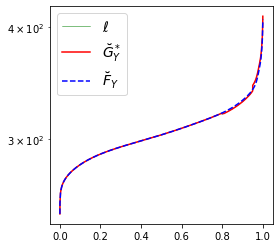

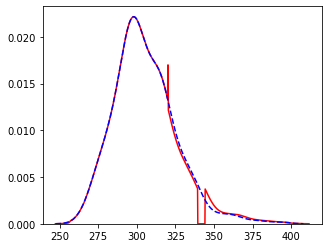

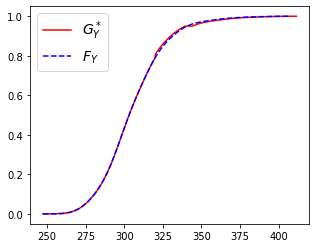

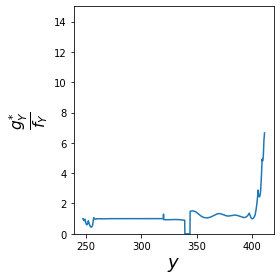

Sensitivity measure for X1 has been calculated.
Sensitivity measure for X2 has been calculated.
Sensitivity measure for X3 has been calculated.
Sensitivity measure for X4 has been calculated.
Sensitivity measure for X5 has been calculated.
Sensitivity measure for X6 has been calculated.
Sensitivity measure for X7 has been calculated.
Sensitivity measure for X8 has been calculated.
Sensitivity measure for X9 has been calculated.
Sensitivity measure for X10 has been calculated.
lambda =  [171.48034038  -1.22786485   0.52626807]
 WD =  6.607663528460549
 RM, Utility =  [339.16000324 367.28992415] 25.043369446832067
 Targets =  [339.16000293 367.28992382] 25.043369014187874
 Base =  [335.8019831  356.59215905] 24.79541486553255




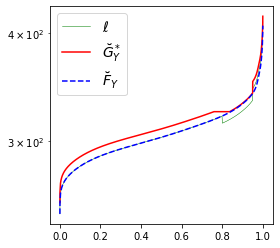

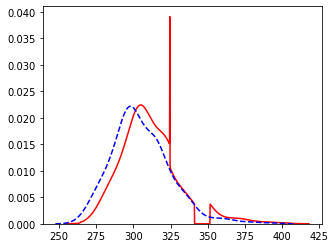

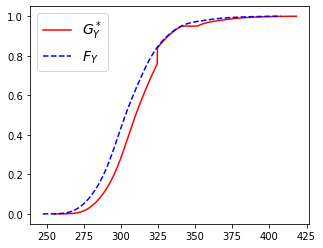

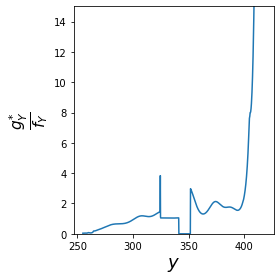

Sensitivity measure for X1 has been calculated.
Sensitivity measure for X2 has been calculated.
Sensitivity measure for X3 has been calculated.
Sensitivity measure for X4 has been calculated.
Sensitivity measure for X5 has been calculated.
Sensitivity measure for X6 has been calculated.
Sensitivity measure for X7 has been calculated.
Sensitivity measure for X8 has been calculated.
Sensitivity measure for X9 has been calculated.
Sensitivity measure for X10 has been calculated.


In [17]:
# Run optimization
RM_P = StressModel.get_risk_measure_baseline()
Utility_P = StressModel.get_hara_utility(a, b(eta), eta, StressModel.u, StressModel.F_inv)

# StressModel.plot_copula_baseline_all(folder + f'hara-es/copula/data', save=True)

for i in range(len(utility_stresses)):
    utility_stress = utility_stresses[i]
    rm_stress = rm_stresses[i]

    _, _, _, fig = StressModel.optimise_HARA(a, b(eta), eta, Utility_P * (1 + utility_stress / 100),
                                             RM_P * np.array([1 + rm_stress[0] / 100, 1 + rm_stress[1] / 100]))

    filename = folder + f'hara-es/data_utility_{utility_stress}_ES_{rm_stress[0]}_{rm_stress[1]}'
    # fig.savefig(filename + '_inv.pdf', format='pdf')

    StressModel.plot_dist(filename, type="Utility", save=False)
    
    if 'x' in data:
#         StressModel.plot_xdensity(filename, save=False)
#         StressModel.plot_copula_all(folder + f'hara-es/copula/data_utility_{utility_stress}_ES_{rm_stress[0]}_{rm_stress[1]}',
#                                     save=True, title=f'utility {utility_stress}% | $ES_{{80}}$ {rm_stress[0]}% | $ES_{{95}}$ {rm_stress[1]}%')
#         bivariate_s = []
#         level = 0.95
#         for k in range(10):
#             temp = []
#             for l in range(10):
#                 s = lambda x1, x2: (x1 > gamma.ppf(level, a=5, loc=25, scale=0.2 * (k + 1)))*(x2 > gamma.ppf(level, a=5, loc=25, scale=0.2 * (l + 1)))
#                 measure = StressModel.reverse_sensitivity_measure_bivariate(s, StressModel.data['x'][:, k],
#                                                                             StressModel.data['x'][:, l])
#                 temp.append(measure)
#             bivariate_s.append(temp)
    
#         gen_sensitivity_df = pd.DataFrame(bivariate_s, columns = [f'L{i+1}' for i in range(10)],
#                                          index = [f'L{i+1}' for i in range(10)])
#         gen_sensitivity_df.to_csv(folder + f'hara-es/data_utility_{utility_stress}_ES_{rm_stress[0]}_{rm_stress[1]}_sensitivity_bivariate_stats_level_{level}.csv')
            
        S1 = np.zeros(10)
        S2 = np.zeros(10)
        for k in range(10):
            # Get s:R->R
            level1 = 0.95
            level2 = 0.8
            s1 = lambda x: x > gamma.ppf(level1, a=5, loc=25, scale=0.2 * (k + 1))
            s2 = lambda x: x > gamma.ppf(level2, a=5, loc=25, scale=0.2 * (k + 1))
            S1[k] = StressModel.reverse_sensitivity_measure(s1, StressModel.data['x'][:, k])
            S2[k] = StressModel.reverse_sensitivity_measure(s2, StressModel.data['x'][:, k])
        S3 = StressModel.reverse_sensitivity_measure(lambda x: x, StressModel.data['x'])
       
        sensitivity_measures1.append(S1)
        sensitivity_measures2.append(S2)
        sensitivity_measures3.append(S3)

        results = StressModel.alternate_sensitivity_measure()
        alt_sensitivity_measures.append(results[0])
        delta_P.append(results[1])
        delta_Q.append(results[2])

        P_ranks = np.argsort(np.argsort(-delta_P[i])) + 1
        Q_ranks = np.argsort(np.argsort(-delta_Q[i])) + 1
        alt_sensitivity_df = pd.DataFrame({'Reverse Sensitivity Measure s(L) = L': list(sensitivity_measures3[i]),
                                           'Reverse Sensitivity Measure s(Li) = I{Li > F_inv(0.95)}': list(sensitivity_measures1[i]),
                                           'Reverse Sensitivity Measure s(Li) = I{Li > F_inv(0.8)}': list(sensitivity_measures2[i]),
                                           'Alternate Sensitivity Measure': list(alt_sensitivity_measures[i]),
                                           'delta_P': list(delta_P[i]),
                                           'P_rank': list(P_ranks),
                                           'delta_Q': list(delta_Q[i]),
                                           'Q_rank': list(Q_ranks)
                                           }, index=[f'X{k + 1}' for k in range(len(alt_sensitivity_measures[i]))])
        alt_sensitivity_df.to_csv(folder + f'hara-es/data_utility_{utility_stress}_ES_{rm_stress[0]}_{rm_stress[1]}_sensitivity_stats.csv')
        labels.append(f'utility {utility_stress}% | $ES_{{80}}$ {rm_stress[0]}% | $ES_{{95}}$ {rm_stress[1]}%')


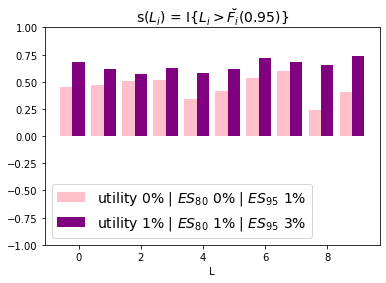

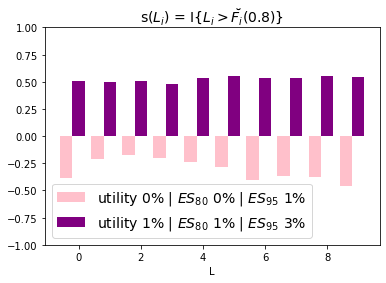

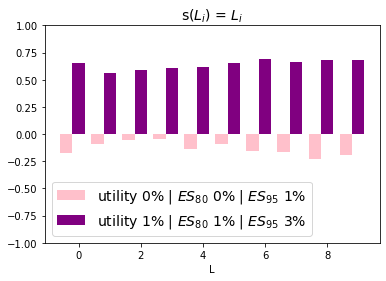

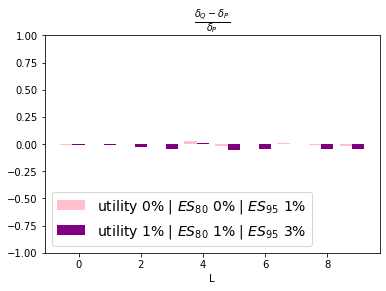

In [19]:
# Sensitivity
colors = colors + ['pink', 'purple', 'blue']
if 'x' in data:
    StressModel.plot_sensitivities(sensitivity_measures1, labels=labels, colors=colors,
                               title=r's($L_i$) = I{$L_i > \breve{F_i}(0.95)$}', save=False,
                               filename=f'Plots/ex/hara-es/data_ES_utility_sensitivity_95.pdf')
    StressModel.plot_sensitivities(sensitivity_measures2, labels=labels, colors=colors,
                               title=r's($L_i$) = I{$L_i > \breve{F_i}(0.8)$}', save=False,
                               filename=f'Plots/ex/hara-es/data_ES_utility_sensitivity_80.pdf')
    StressModel.plot_sensitivities(sensitivity_measures3, labels=labels, colors=colors,
                               title=r's($L_i$) = $L_i$', save=False,
                               filename=folder + f'hara-es/data_ES_utility_sensitivity.pdf')
    
    StressModel.plot_sensitivities(alt_sensitivity_measures, filename = folder + f'hara-es/data_ES_utility_sensitivity_alt_sensitivity.pdf',
                               labels=labels, colors=colors, title=r'$\frac{\delta_Q - \delta_P}{\delta_P}$', save=True)
